In [2]:
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn import metrics 
from scipy import stats

import sys
# sys.path.insert(0, '')
import importlib
from dredFISH.Analysis import basicu

importlib.reload(basicu)

sns.set_context('talk')

# Load data

In [3]:
f = '../data_dump/candidate_genes_vincent_0328.csv'
df0 = pd.read_csv(f)
df0 = df0.sort_values(['Subclass', 'Type/Gradient'])
df0 = df0[df0['Gene']!='Neurod1']
df0 = df0.set_index('Gene')
df0

,Subclass,Type/Gradient,Function,Priority,Note
Gene,,,,,
Baz1a,L2/3,A<B>C,TF,***,NaN
Trpc6,L2/3,A<B>C,IC,***,NaN
Bdnf,L2/3,A<B>C,CAM,***,NaN
Sox5,L2/3,A<B>C,TF,NaN,NaN
Nrp1,L2/3,A<B>C,CAM,***,NaN
...,...,...,...,...,...
Ngb,L2/3,NaN,other,NaN,NaN
Penk,L2/3,NaN,other,NaN,NaN
Chrm2,"L2/3, L4",C>B=A,IC,***,NaN


In [4]:
%%time
adata = ad.read('../data_dump/P38_glut_genes_v3_annot.h5ad')
adata

CPU times: user 158 ms, sys: 541 ms, total: 698 ms
Wall time: 698 ms


AnnData object with n_obs × n_vars = 5837 × 86
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass', 'embed_1', 'embed_2', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7', 'PC_8', 'PC_9', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20', 'PC_21', 'PC_22', 'PC_23', 'PC_24', 'PC_25', 'PC_26', 'PC_27', 'PC_28', 'PC_29', 'PC_30', 'PC_31', 'PC_32', 'PC_33', 'PC_34', 'PC_35', 'PC_36', 'PC_37', 'PC_38', 'PC_39', 'PC_40', 'PC_41', 'PC_42', 'PC_43', 'PC_44', 'PC_45', 'PC_46', 'PC_47', 'PC_48', 'PC_49', 'PC_50', 'PC_51', 'PC_52', 'PC_53', 'PC_54', 'PC_55', 'PC_56', 'PC_57', 'PC_58', 'PC_59', 'PC_60', 'PC_61', 'PC_62', 'PC_63', 'PC_64', 'PC_65', 'PC_66', 'PC_67', 'PC_68', 'PC_69', 'PC_70', 'PC_71', 'PC_72', 'PC_73', 'PC_74', 'PC_75', 'PC_76', 'PC_77', 'PC_78', 'PC_79', 'PC_80', 'PC_81', 'PC_82', 'PC_83', 'PC_84', 'PC_8

In [5]:
# %%time
# # UMAP
# embed = umap.UMAP(n_components=2, random_state=0).fit_transform(adata.X)
# adata.obs['embed_1'] = embed[:,0]
# adata.obs['embed_2'] = embed[:,1]

# adata.write('../data_dump/P38_glut_genes_v3_annot.h5ad')

#  Utilities

In [6]:
def get_r2(y, yhat):
    """
    """
    r2 = 1-np.power(y-yhat, 2).sum()/np.power(y-np.mean(y), 2).sum()
    return r2

def get_mse(y, yhat):
    """
    """
    mse = np.power(y-yhat, 2).mean()
    return mse
    
def get_pearsonr(y, yhat):
    """
    """
    r, p = stats.pearsonr(y, yhat)
    return r

In [7]:
def regression_pipe(X, y, alpha):
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    ygs = np.empty(len(y))
    yps = np.empty(len(y))
    
    mse_s = []
    l0s = []
    l1s = []
    
    for train_idx, test_idx, in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # build model
        model = Lasso(alpha=alpha, random_state=0)
        # train
        model.fit(X_train, y_train)
        # test
        yp = model.predict(X_test)
        # evaluation
        mse = np.power(yp-y_test, 2).mean()
        l0 = (np.abs(model.coef_) > 1e-6).sum() 
        l1 = np.abs(model.coef_).sum()

        # add
        l0s.append(l0)
        l1s.append(l1)
        mse_s.append(mse)
        
        ygs[test_idx] = y_test
        yps[test_idx] = yp
    
    return ygs, yps, mse_s, l0s, l1s

def tuning_regression(X, y, alphas):
    """
    """
    res = []
    ressum = []
    for alpha in alphas:
        print(alpha)
        # run
        ygs, yps, mse_s, l0s, l1s = regression_pipe(X, y, alpha)
        res.append((ygs, yps, mse_s, l0s, l1s))
        ressum.append({
           'Reg Strength': alpha,
           'MSE': np.mean(mse_s),
           'r2': get_r2(ygs, yps),
           'coef L0': np.mean(l0s),
           'coef L1': np.mean(l1s),
          })
    
    ressum = pd.DataFrame(ressum)
    return res, ressum

def plot_regression_pipe(ax, ygs, ypgs, clusters, title="", legend=True):
    """
    """
    r2 = get_r2(ygs, yps)
    dfplot = pd.DataFrame()
    dfplot['Ground truth'] = ygs
    dfplot['Prediction'] = yps
    dfplot['Cluster'] = clusters 
    sns.scatterplot(data=dfplot, 
                    x='Ground truth',
                    y='Prediction',
                    hue='Cluster',
                    hue_order=np.sort(dfplot['Cluster'].unique()),
                    edgecolor='none',
                    s=5,
                    ax=ax,
                   )

    scale = min(max(ygs), max(yps))
    ax.plot([0, scale], [0, scale], color='k', linestyle='--')
    ax.set_title(f"{title}")
    ax.text(1, 0.1, f'r2={r2:.2f}', ha='right', transform=ax.transAxes)
    sns.despine(ax=ax)
    if legend:
        ax.legend(bbox_to_anchor=(1,1))
    else:
        ax.get_legend().remove()
    
def plot_ressum_reg(ressum, evalcol='AUPR', scale='linear', title=''):
    """
    """
    fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
    ax = axs[0]
    ax.plot(ressum['Reg Strength'], ressum['coef L0'], '-o')
    ax.set_ylabel('# genes used')
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    ax.set_title(title)
    
    ax = axs[1]
    ax.plot(ressum['Reg Strength'], ressum[evalcol], '-o')
    ax.set_ylabel(evalcol)
    ax.set_xlabel('Regularization')
    ax.set_ylim(ymax=1.02)
    ax.grid()
    sns.despine(ax=ax)
    ax.set_xscale(scale)
    if scale == 'linear':
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-4,-4))
    
    plt.show()

# Regression example

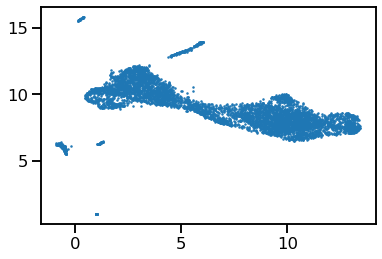

In [8]:
plt.scatter(adata.obs['embed_1'], 
            adata.obs['embed_2'],
            s=1,
           )

(5837, 86) (5837,)


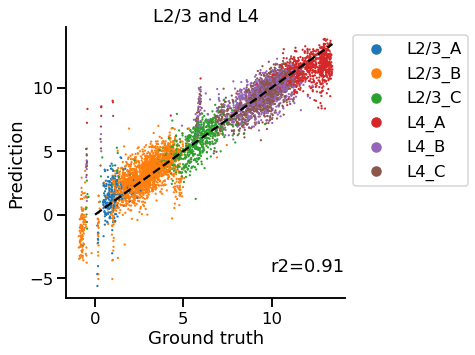

In [9]:
# data
X = adata.X
y = adata.obs['embed_1'].values 
clusters = adata.obs['cluster'].values
print(X.shape, y.shape)

# run
alpha = 1e-3 
ygs, yps, mse_s, l0s, l1s = regression_pipe(X, y, alpha)
                                   
# vis
fig, ax = plt.subplots(1,1,figsize=(5*1,5))
plot_regression_pipe(ax, ygs, yps, clusters, title='L2/3 and L4')
plt.show()

# L2/3 and L4 Tuning

In [10]:
# data
X = adata.X
y = adata.obs['embed_1'].values 
clusters = adata.obs['cluster'].values
print(X.shape, y.shape)

(5837, 86) (5837,)


In [11]:
# run
# alphas = np.linspace(4e-4, 5e-4, 11) # micro
alphas = np.logspace(-4, 4, 9) # macro
# alphas = np.linspace(1e-4, 1e-3, 10) # macro
# alphas = [1, 10]

res, ressum = tuning_regression(X, y, alphas)

0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0


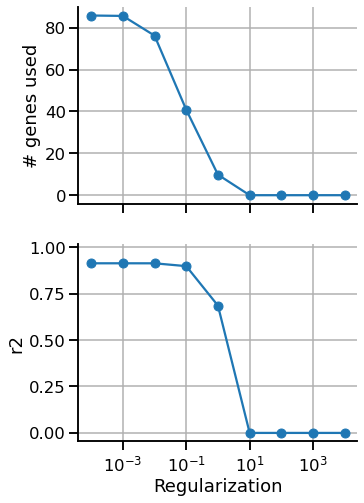

In [12]:
plot_ressum_reg(ressum, evalcol='r2', scale='log')

In [13]:
# c = 5e-4
for alpha in alphas:
    # which gene?
    model = Lasso(alpha=alpha, random_state=0)
    model.fit(X, y)
    cond = np.abs(model.coef_.reshape(-1,)) > 1e-6
    used_genes = adata.var[cond].index.values
    print(f'alpha={alpha:.2g}, {len(used_genes)} genes used: ', used_genes)

alpha=0.0001, 86 genes used:  ['Adamts2' 'Agmat' 'Astn2' 'Baz1a' 'Bdnf' 'Cacna1h' 'Cbln2' 'Cbr3' 'Ccbe1'
 'Cdh12' 'Cdh13' 'Cdh20' 'Cdh4' 'Chrm2' 'Chrm3' 'Cntn2' 'Cntn5' 'Cntn6'
 'Cntnap1' 'Cntnap2' 'Coch' 'Cux1' 'Dgkb' 'Dscaml1' 'Egfem1' 'Epha10'
 'Epha3' 'Epha6' 'Foxp1' 'Fst' 'Gabrg3' 'Gpc5' 'Gpc6' 'Gria3' 'Grik3'
 'Grm1' 'Grm8' 'Igfbp7' 'Igfn1' 'Igsf11' 'Igsf9b' 'Kcna1' 'Kcnh5' 'Kcnip3'
 'Kcnn3' 'Kcnq5' 'Kirrel3' 'Lgi2' 'Lynx1' 'Mdga1' 'Meis2' 'Met' 'Mkx'
 'Ncam2' 'Ngb' 'Nptx2' 'Nr4a3' 'Nrp1' 'Ntng1' 'Otof' 'Pcdh15' 'Pcdh19'
 'Penk' 'Pld5' 'Plxnd1' 'Pou3f2' 'Ptpru' 'Rfx3' 'Robo1' 'Robo3' 'Rorb'
 'Rrad' 'S100a6' 'Scn1a' 'Sdk2' 'Sema4a' 'Sema6a' 'Sema6d' 'Sorcs3' 'Sox5'
 'Stard8' 'Tbr1' 'Tenm1' 'Trpc6' 'Whrn' 'Wnt4']
alpha=0.001, 85 genes used:  ['Adamts2' 'Agmat' 'Baz1a' 'Bdnf' 'Cacna1h' 'Cbln2' 'Cbr3' 'Ccbe1' 'Cdh12'
 'Cdh13' 'Cdh20' 'Cdh4' 'Chrm2' 'Chrm3' 'Cntn2' 'Cntn5' 'Cntn6' 'Cntnap1'
 'Cntnap2' 'Coch' 'Cux1' 'Dgkb' 'Dscaml1' 'Egfem1' 'Epha10' 'Epha3'
 'Epha6' 'Foxp1' 'Fst' 'Gab

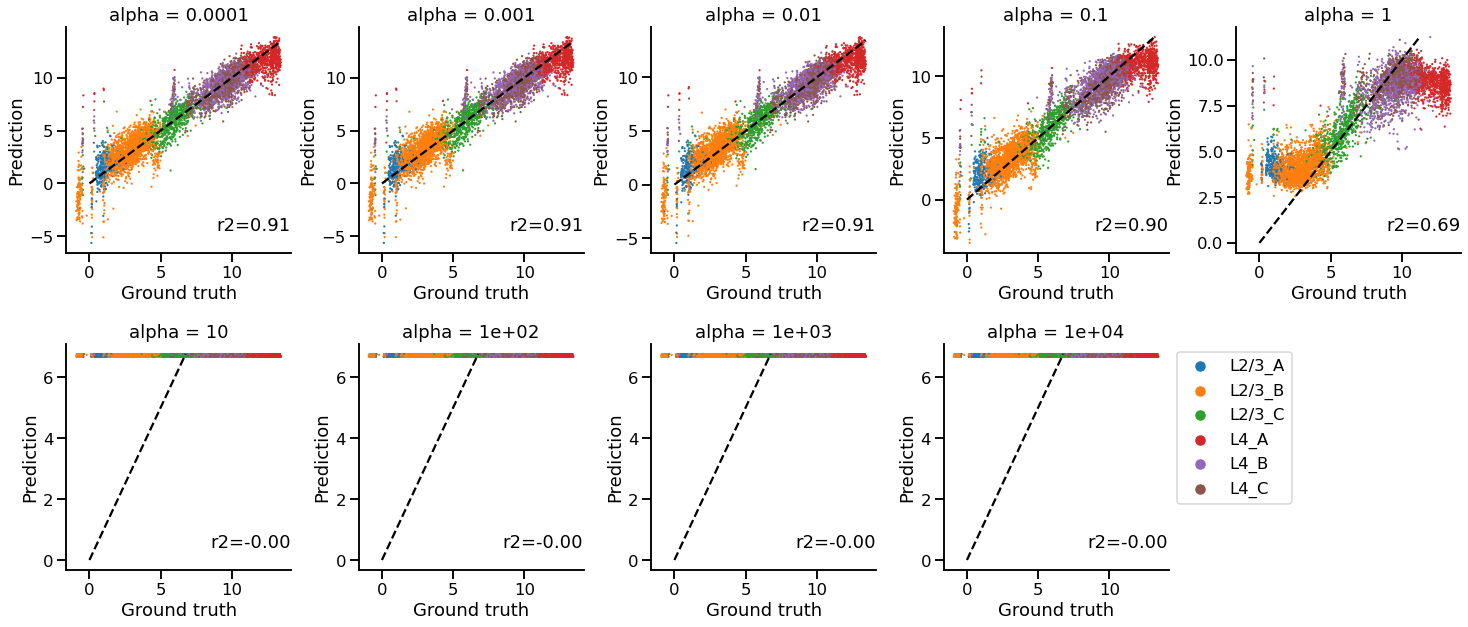

In [14]:
n = len(alphas)
nx = 5
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(5*nx,5*ny))
for i, (oneres, alpha, ax) in enumerate(zip(res, alphas, axs.flat)):
    if i < n-1:
        legend = False
    else:
        legend = True
        
    ygs, yps, _, _, _ = oneres
    plot_regression_pipe(ax, ygs, yps, clusters, title='', legend=legend)
    ax.set_title(f'alpha = {alpha:.2g}')
    
for ax in axs.flat[i+1:]:
    ax.axis('off')
    
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

In [16]:
def get_model_used_genes(model, allgenes):
    """
    """
    abscoef = np.abs(model.coef_.reshape(-1,))
    cond = abscoef > 1e-6 
    
    if cond.sum() > 0:
        used_abscoef = abscoef[cond]
        used_genes = allgenes[cond]
        used_coefidx = np.argsort(used_abscoef)[::-1]

        return used_abscoef[used_coefidx], used_genes[used_coefidx]
    else:
        return 0,0

In [19]:
selected_alpha = 0.1
allgenes = adata.var.index.values
model = Lasso(alpha=selected_alpha, random_state=0)
model.fit(X, y)
absweights, ugenes = get_model_used_genes(model, allgenes)
print(len(ugenes), absweights, ugenes)


40 [0.56846726 0.5083247  0.440899   0.41499802 0.4128907  0.33314303
 0.29864034 0.29675484 0.29098246 0.25831914 0.22854991 0.20758867
 0.19378401 0.16243175 0.14960524 0.13643067 0.13521126 0.11227936
 0.11188324 0.11144242 0.10888644 0.09443807 0.09031275 0.08649872
 0.08137737 0.08128972 0.07876988 0.07491864 0.07312207 0.07202394
 0.06813988 0.06386348 0.06065274 0.0571509  0.05205857 0.03920941
 0.02561827 0.01776213 0.01238846 0.00286121] ['Agmat' 'Cntn5' 'Rorb' 'Pcdh15' 'Chrm3' 'Ncam2' 'Meis2' 'Cux1' 'Dscaml1'
 'Ngb' 'Whrn' 'Grm1' 'Dgkb' 'Gabrg3' 'Otof' 'S100a6' 'Ccbe1' 'Tenm1'
 'Rfx3' 'Kcnip3' 'Fst' 'Igsf11' 'Epha3' 'Kcnn3' 'Sorcs3' 'Cbr3' 'Coch'
 'Stard8' 'Mdga1' 'Gria3' 'Ntng1' 'Kcnh5' 'Plxnd1' 'Gpc6' 'Adamts2' 'Mkx'
 'Cdh20' 'Pld5' 'Penk' 'Trpc6']


In [20]:
Xk, xclsts = basicu.group_mean(X, adata.obs['cluster'])
Xk = np.array(Xk)
Xk = pd.DataFrame(Xk, index=xclsts, columns=allgenes)
Xk.shape, xclsts.shape, xclsts

((6, 86),
 (6,),
 array(['L2/3_A', 'L2/3_B', 'L2/3_C', 'L4_A', 'L4_B', 'L4_C'], dtype=object))

In [21]:
Xplot = Xk.T.loc[ugenes] #[gene_order].T
# mat, rows, cols = basicu.diag_matrix_rows(Xplot.values)
# Xplot = pd.DataFrame(mat, index=Xplot.index.values[rows], columns=Xplot.columns.values[cols])
Xannot = df0.loc[Xplot.index][['Subclass', 'Type/Gradient', 'Function', 'Priority']].fillna('')

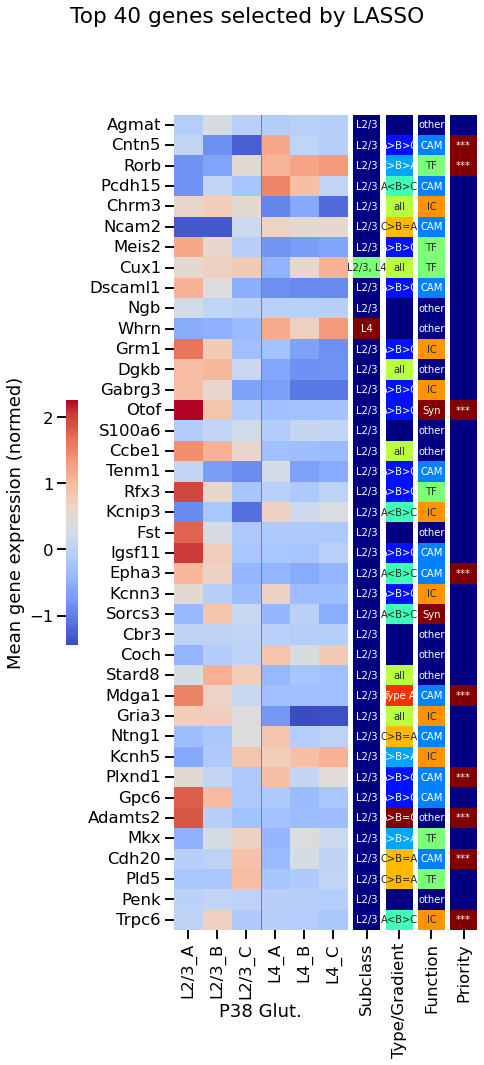

In [23]:
mosaic = "A"*10+"BCDE"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8,15))
ax = axs['A']
sns.heatmap(Xplot, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.3, label='Mean gene expression (normed)', location='left', pad=0.3),
            ax=ax)
ax.axvline(3, color='gray', linewidth=1)
ax.set_yticklabels(ax.get_yticklabels(), 
                   # fontsize=10, 
                   rotation=0)
ax.set_xlabel('P38 Glut.')

for i, ax in enumerate([axs['B'], axs['C'], axs['D'], axs['E']]):
    nums, catgs = pd.factorize(Xannot.iloc[:,i])
    # ax.set_title(Xannot.columns[i], fontsize=12, rotation=90)
    sns.heatmap(nums.reshape(-1,1), 
                annot=pd.Series(catgs.values[nums]).values.reshape(-1,1),
                annot_kws={'size': 10},
                yticklabels=False,
                # xticklabels=False,
                fmt='',
                cbar=False,
                cmap='jet',
                ax=ax
               )
    ax.set_xticklabels([Xannot.columns[i]], rotation=90)
fig.suptitle("Top 40 genes selected by LASSO")
plt.show()

# L2/3 only tuning

In [24]:
# data
cond = adata.obs['cluster'].str.contains('L2/3')
adatasub = adata[cond].copy()
X = adatasub.X
y = adatasub.obs['embed_1'].values 
clusters = adatasub.obs['cluster'].values
print(X.shape, y.shape)

(2818, 86) (2818,)


In [25]:
# run
# alphas = np.linspace(4e-4, 5e-4, 11) # micro
alphas = np.logspace(-4, 4, 9) # macro
# alphas = np.linspace(1e-4, 1e-3, 10) # macro
# alphas = [1, 10]

res, ressum = tuning_regression(X, y, alphas)

0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0


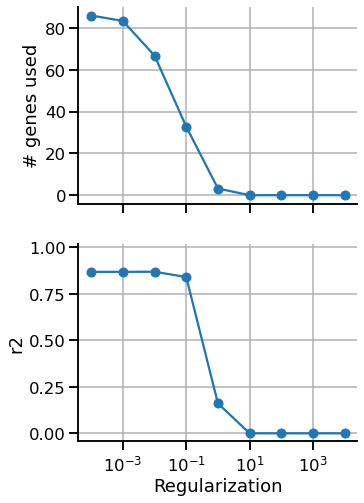

In [26]:
plot_ressum_reg(ressum, evalcol='r2', scale='log')

In [27]:
# c = 5e-4
for alpha in alphas:
    # which gene?
    model = Lasso(alpha=alpha, random_state=0)
    # model.fit(X[:int(0.8*len(y))], y[:int(0.8*len(y))])
    model.fit(X, y)
    cond = np.abs(model.coef_.reshape(-1,)) > 1e-6
    used_genes = adata.var[cond].index.values
    print(f'alpha={alpha:.2g}, {len(used_genes)} genes used: ', used_genes)

alpha=0.0001, 86 genes used:  ['Adamts2' 'Agmat' 'Astn2' 'Baz1a' 'Bdnf' 'Cacna1h' 'Cbln2' 'Cbr3' 'Ccbe1'
 'Cdh12' 'Cdh13' 'Cdh20' 'Cdh4' 'Chrm2' 'Chrm3' 'Cntn2' 'Cntn5' 'Cntn6'
 'Cntnap1' 'Cntnap2' 'Coch' 'Cux1' 'Dgkb' 'Dscaml1' 'Egfem1' 'Epha10'
 'Epha3' 'Epha6' 'Foxp1' 'Fst' 'Gabrg3' 'Gpc5' 'Gpc6' 'Gria3' 'Grik3'
 'Grm1' 'Grm8' 'Igfbp7' 'Igfn1' 'Igsf11' 'Igsf9b' 'Kcna1' 'Kcnh5' 'Kcnip3'
 'Kcnn3' 'Kcnq5' 'Kirrel3' 'Lgi2' 'Lynx1' 'Mdga1' 'Meis2' 'Met' 'Mkx'
 'Ncam2' 'Ngb' 'Nptx2' 'Nr4a3' 'Nrp1' 'Ntng1' 'Otof' 'Pcdh15' 'Pcdh19'
 'Penk' 'Pld5' 'Plxnd1' 'Pou3f2' 'Ptpru' 'Rfx3' 'Robo1' 'Robo3' 'Rorb'
 'Rrad' 'S100a6' 'Scn1a' 'Sdk2' 'Sema4a' 'Sema6a' 'Sema6d' 'Sorcs3' 'Sox5'
 'Stard8' 'Tbr1' 'Tenm1' 'Trpc6' 'Whrn' 'Wnt4']
alpha=0.001, 85 genes used:  ['Adamts2' 'Agmat' 'Astn2' 'Baz1a' 'Bdnf' 'Cacna1h' 'Cbln2' 'Cbr3' 'Ccbe1'
 'Cdh12' 'Cdh13' 'Cdh20' 'Cdh4' 'Chrm2' 'Chrm3' 'Cntn2' 'Cntn5' 'Cntnap1'
 'Cntnap2' 'Coch' 'Cux1' 'Dgkb' 'Dscaml1' 'Egfem1' 'Epha10' 'Epha3'
 'Epha6' 'Foxp1' 'Fst' 'Gab

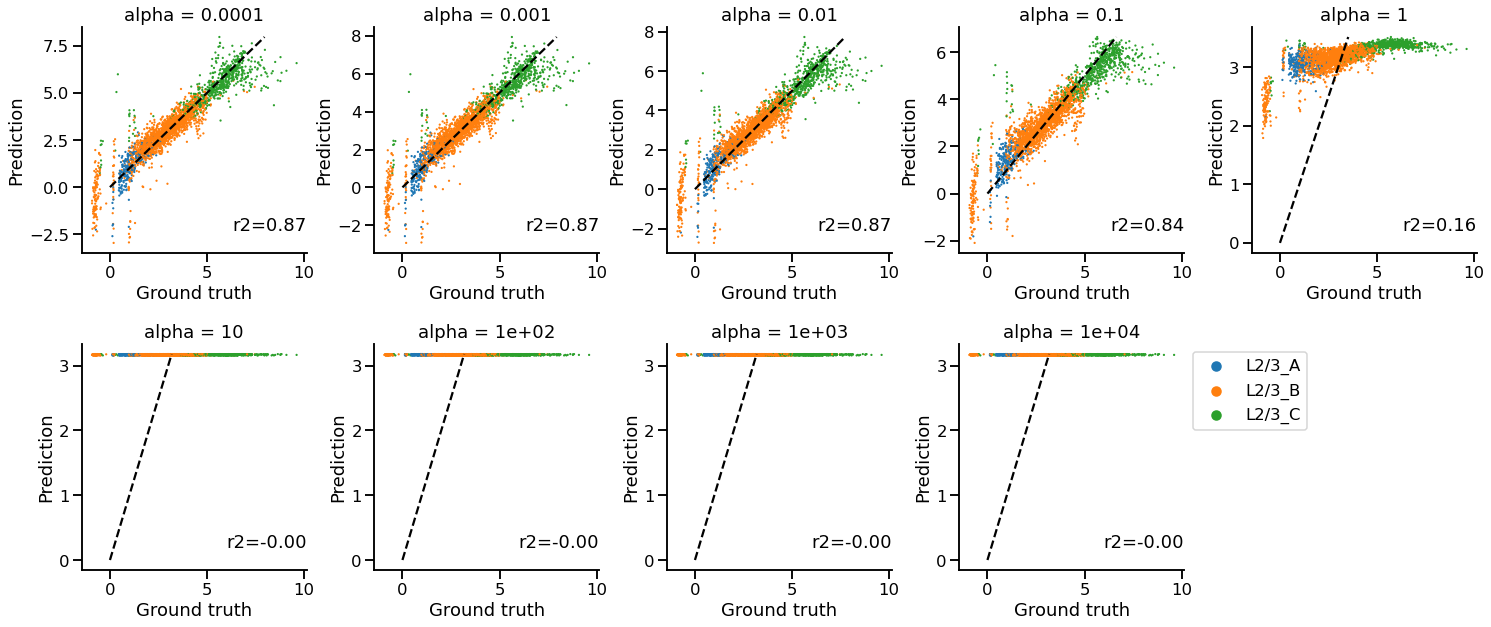

In [28]:
n = len(alphas)
nx = 5
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(5*nx,5*ny))
for i, (oneres, alpha, ax) in enumerate(zip(res, alphas, axs.flat)):
    if i < n-1:
        legend = False
    else:
        legend = True
        
    ygs, yps, _, _, _ = oneres
    plot_regression_pipe(ax, ygs, yps, clusters, title='', legend=legend)
    ax.set_title(f'alpha = {alpha:.2g}')
    
for ax in axs.flat[i+1:]:
    ax.axis('off')
    
fig.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

In [35]:
selected_alpha = 0.1
allgenes = adata.var.index.values
model = Lasso(alpha=selected_alpha, random_state=0)
model.fit(X, y)
absweights, ugenes = get_model_used_genes(model, allgenes)
print(len(ugenes), absweights, ugenes)


34 [0.45666492 0.20064823 0.18226762 0.17345765 0.13298462 0.12929662
 0.11031938 0.11022168 0.10806664 0.10711033 0.10572949 0.09851377
 0.09844457 0.09703507 0.08904256 0.08840228 0.08689899 0.08664139
 0.08658852 0.08100744 0.04831687 0.04347119 0.03849023 0.03746423
 0.02856925 0.02524173 0.02361418 0.01126991 0.01041238 0.00663097
 0.00557507 0.00487444 0.00453315 0.00408508] ['Agmat' 'Chrm2' 'Ncam2' 'Rorb' 'Gabrg3' 'Ngb' 'Grm1' 'Gpc6' 'Otof'
 'Cntnap2' 'Rfx3' 'Fst' 'Cdh12' 'Dscaml1' 'Kirrel3' 'Astn2' 'Adamts2'
 'Cbr3' 'Penk' 'Igsf11' 'Epha3' 'Igsf9b' 'Mdga1' 'S100a6' 'Sema6d'
 'Epha10' 'Pld5' 'Met' 'Epha6' 'Ccbe1' 'Kcnh5' 'Gpc5' 'Dgkb' 'Pcdh19']


In [36]:
Xk, xclsts = basicu.group_mean(X, adatasub.obs['cluster'])
Xk = np.array(Xk)
Xk = pd.DataFrame(Xk, index=xclsts, columns=allgenes)
Xk.shape, xclsts.shape, xclsts

((3, 86), (3,), array(['L2/3_A', 'L2/3_B', 'L2/3_C'], dtype=object))

In [37]:
Xplot = Xk.T.loc[ugenes] #[gene_order].T
# mat, rows, cols = basicu.diag_matrix_rows(Xplot.values)
# Xplot = pd.DataFrame(mat, index=Xplot.index.values[rows], columns=Xplot.columns.values[cols])
Xannot = df0.loc[Xplot.index][['Subclass', 'Type/Gradient', 'Function', 'Priority']].fillna('')

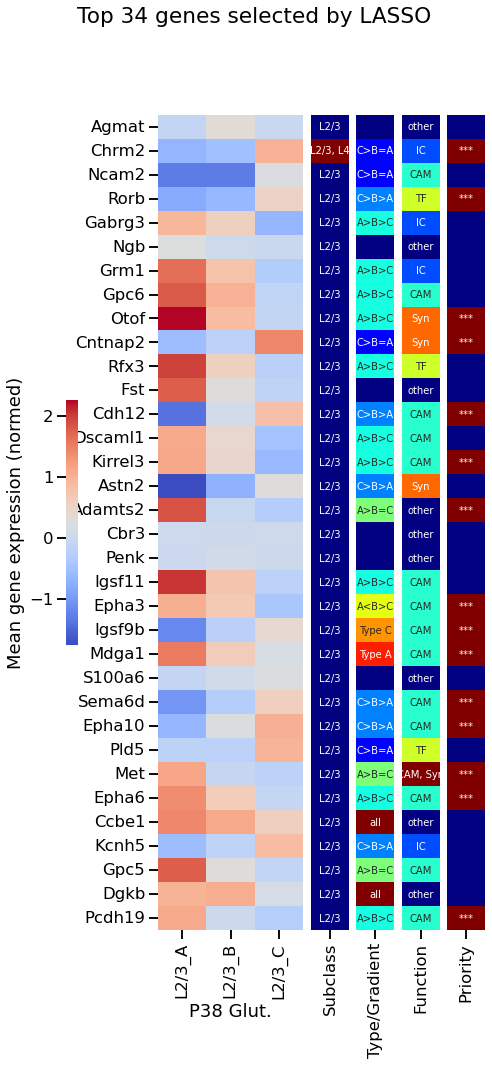

In [40]:
mosaic = "A"*6+"BCDE"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8,15))
ax = axs['A']
sns.heatmap(Xplot, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.3, label='Mean gene expression (normed)', location='left', pad=0.3),
            ax=ax)
ax.axvline(3, color='gray', linewidth=1)
ax.set_yticklabels(ax.get_yticklabels(), 
                   # fontsize=10, 
                   rotation=0)
ax.set_xlabel('P38 Glut.')

for i, ax in enumerate([axs['B'], axs['C'], axs['D'], axs['E']]):
    nums, catgs = pd.factorize(Xannot.iloc[:,i])
    # ax.set_title(Xannot.columns[i], fontsize=12, rotation=90)
    sns.heatmap(nums.reshape(-1,1), 
                annot=pd.Series(catgs.values[nums]).values.reshape(-1,1),
                annot_kws={'size': 10},
                yticklabels=False,
                # xticklabels=False,
                fmt='',
                cbar=False,
                cmap='jet',
                ax=ax
               )
    ax.set_xticklabels([Xannot.columns[i]], rotation=90)
fig.suptitle(f"Top {len(Xplot)} genes selected by LASSO")
plt.show()